## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence


/home/dcg-adlr-rafaelvalle-source.cosmos597/repos/nvidia/tacotron2/plotting_utils.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use("Agg")


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams("distributed_run=False,mask_padding=False")
hparams.sampling_rate = 22050
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024

INFO:tensorflow:Parsing command line hparams: distributed_run=False,mask_padding=False


#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_statedict"

model = load_model(hparams)
try:
    model = model.module
except:
    pass
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path)['state_dict'].items()})
_ = model.eval()

#### Load WaveGlow for mel2audio synthesis

In [5]:
waveglow_path = 'waveglow_old.pt'
waveglow = torch.load(waveglow_path)['model']

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'glow_old.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'glow_old.WN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


#### Prepare text input

In [6]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

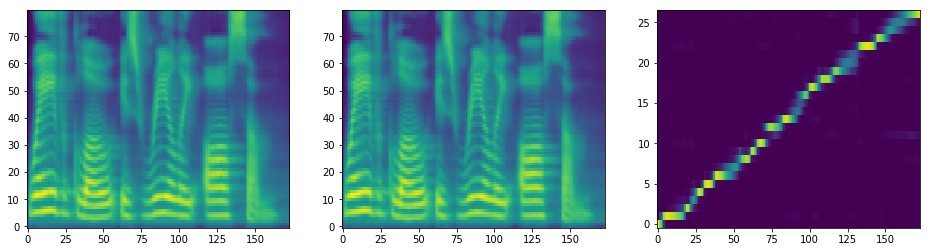

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [8]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)